In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Read the Data

In [32]:
data = pd.read_csv('train.csv' ,parse_dates=['Tarih'], index_col='Tarih')
data

,Dağıtılan Enerji (MWh)
Tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701
...,...
2022-07-31 19:00:00,2492.489498
2022-07-31 20:00:00,2479.958245
2022-07-31 21:00:00,2485.016884


In [34]:
future_data = pd.read_csv('future.csv')
future_data

,Unnamed: 0,Tarih,Dağıtılan Enerji (MWh)
0,0,2022-08-01 00:00:00,NaN
1,1,2022-08-01 01:00:00,NaN
2,2,2022-08-01 02:00:00,NaN
3,3,2022-08-01 03:00:00,NaN
4,4,2022-08-01 04:00:00,NaN
...,...,...,...
739,739,2022-08-31 19:00:00,NaN
740,740,2022-08-31 20:00:00,NaN
741,741,2022-08-31 21:00:00,NaN
742,742,2022-08-31 22:00:00,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40152 entries, 2018-01-01 00:00:00 to 2022-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40152 non-null  float64
dtypes: float64(1)
memory usage: 627.4 KB


In [4]:
data.head()

,Dağıtılan Enerji (MWh)
Tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701


In [5]:
data.tail()

,Dağıtılan Enerji (MWh)
Tarih,
2022-07-31 19:00:00,2492.489498
2022-07-31 20:00:00,2479.958245
2022-07-31 21:00:00,2485.016884
2022-07-31 22:00:00,2396.574255
2022-07-31 23:00:00,2285.252844


In [6]:
# pip install statsmodels pandas_datareader yfinance scikit-learn

# Feature Engineering

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import sqrt
from pandas_datareader import data as pdr
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Train | Test Split

In [8]:
X_test = data.loc[data.index > '2022-07-23 23:00:00'].copy()
X_train = data.loc[data.index <= '2022-07-23 23:00:00'].copy()

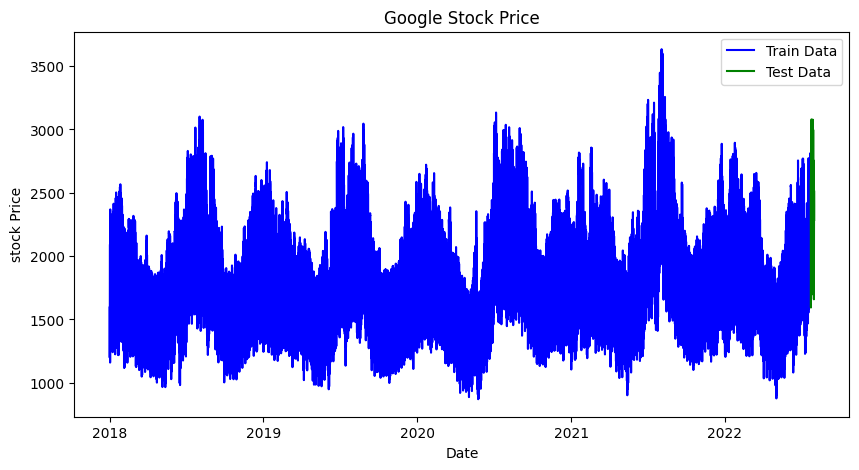

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(X_train.index, X_train["Dağıtılan Enerji (MWh)"]  , label="Train Data", color='blue')
plt.plot(X_test.index, X_test["Dağıtılan Enerji (MWh)"] , label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('stock Price')
plt.title('Google Stock Price')
plt.legend()
plt.show()

In [10]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

check_stationarity(X_train["Dağıtılan Enerji (MWh)"] ) 

# Bu sonuçlar, bir zaman serisi verisi üzerinde yapılan Dickey-Fuller testinin sonuçlarını göstermektedir. 
# Bu test, bir zaman serisinin durağan olup olmadığını belirlemek için kullanılır. 
# Durağanlık, bir zaman serisinin istatistiksel özelliklerinin zaman içinde sabit kalması anlamına gelir. 
# Bu sonuçlara göre, test istatistiği (-9.589996) kritik değerlerin her biri altında kaldığından, zaman serisi durağan kabul edilir. 
# Bu sonuçlar, zaman serisinin analizi ve tahmini için daha uygun olan ARIMA modellerinin kullanılması için bir gösterge olabilir.
# p-value ve Test Statistic toplamı negatif ve küçük bir değer olduğu için veri setimiz stationary(durağan) diyebiliriz.

### ÖZETLE ###

# Çıkan Test Statistic + p-value değerleri toplamı critical Valuelardan küçükse stationary(durağan) diyebiliriz.

Results of Dickey-Fuller Test:
Test Statistic                -9.589996e+00
p-value                        2.048194e-16
#Lags Used                     5.400000e+01
Number of Observations Used    3.989600e+04
Critical Value (1%)           -3.430514e+00
Critical Value (5%)           -2.861612e+00
Critical Value (10%)          -2.566809e+00
dtype: float64


In [11]:
X_train['Close_diff'] = X_train["Dağıtılan Enerji (MWh)"].diff()
X_train['Close_diff_diff'] = X_train["Dağıtılan Enerji (MWh)"].diff().diff()

In [12]:
X_train

,Dağıtılan Enerji (MWh),Close_diff,Close_diff_diff
Tarih,,,
2018-01-01 00:00:00,1593.944216,NaN,NaN
2018-01-01 01:00:00,1513.933887,-80.010329,NaN
2018-01-01 02:00:00,1402.612637,-111.321250,-31.310921
2018-01-01 03:00:00,1278.527266,-124.085370,-12.764120
2018-01-01 04:00:00,1220.697701,-57.829565,66.255805
...,...,...,...
2022-07-23 10:00:00,2348.870054,151.919294,-60.561672
2022-07-23 11:00:00,2460.258164,111.388109,-40.531184
2022-07-23 12:00:00,2467.819171,7.561007,-103.827102


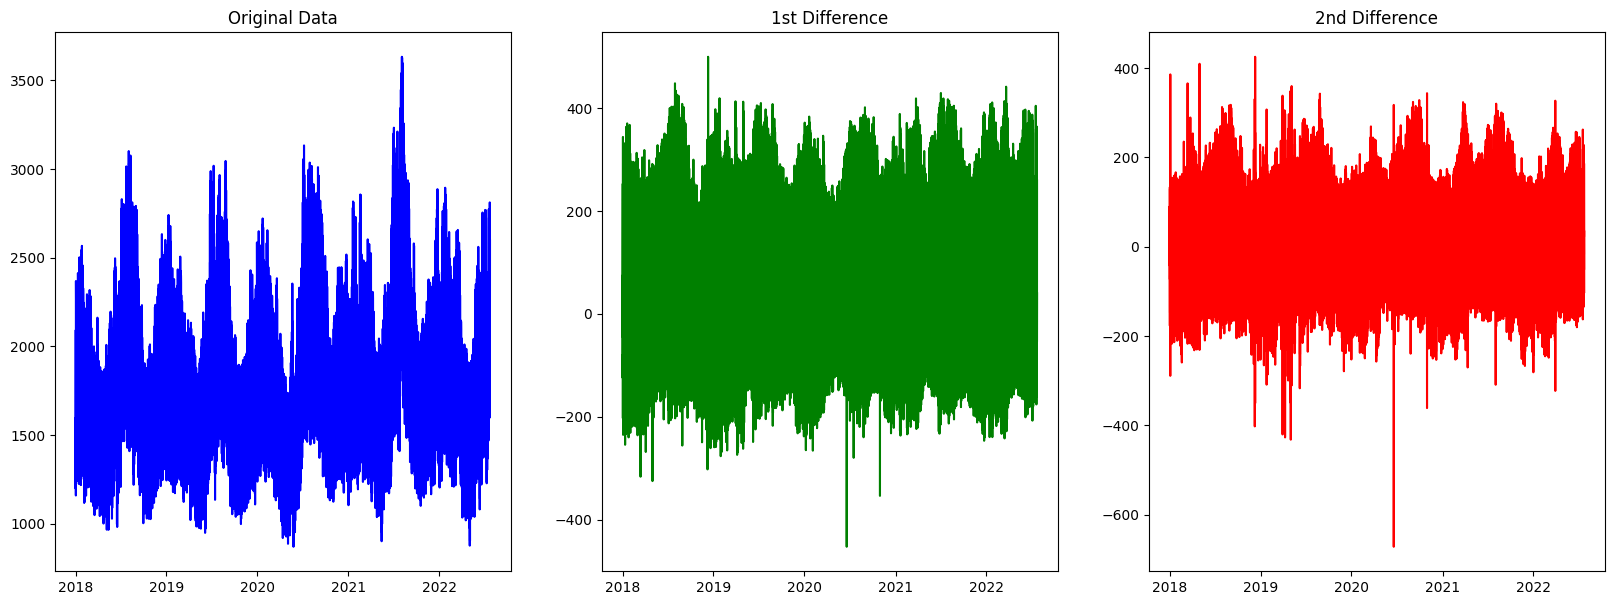

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
ax1.plot(X_train.index, X_train["Dağıtılan Enerji (MWh)"], color='blue')
ax1.set_title('Original Data')
ax2.plot(X_train.index, X_train.Close_diff, color='green')
ax2.set_title('1st Difference')
ax3.plot(X_train.index, X_train.Close_diff_diff, color='red')
ax3.set_title('2nd Difference')
plt.show()

In [14]:
train_df_copy = X_train.copy() 
train_df_copy.index.name = 'Tarih'
train_df_copy.reset_index(inplace= True ) 
train_df_copy[ 'Tarih' ] = pd.to_datetime(train_df_copy[ 'Tarih' ]) 
train_df_copy.groupby(train_df_copy.Tarih. dt.year).agg([ 'mean' , 'std' , 'var' ])

C:\Users\Emincan\AppData\Local\Temp\ipykernel_15808\1690944848.py:5: FutureWarning: ['Tarih'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  train_df_copy.groupby(train_df_copy.Tarih. dt.year).agg([ 'mean' , 'std' , 'var' ])


Dağıtılan Enerji (MWh)                            Close_diff  \
                        mean         std            var       mean   
Tarih                                                                
2018             1789.605306  405.603912  164514.533750   0.026324   
2019             1778.750899  399.832078  159865.690858  -0.010961   
2020             1842.075285  430.519126  185346.717649  -0.010844   
2021             1915.413760  451.006875  203407.200981   0.005399   
2022             1852.045324  413.633235  171092.453102   0.187583   

                                Close_diff_diff                          
              std           var            mean        std          var  
Tarih                                                                    
2018   110.283053  12162.351831        0.001660  81.110986  6578.992070  
2019   112.197027  12588.172784        0.000945  83.719761  7008.998437  
2020   110.495906  12209.345164        0.000192  77.758831  6046.435872  
2021   113.895911  12972.278461        0.000293  78.931805  6230.229837  
2022   115.043303  13234.961453        0.019024  80.244005  6439.100315

In [15]:
check_stationarity(X_train[ 'Close_diff' ].dropna())  # Close_diff de stationary(durağan) çıktı.

Results of Dickey-Fuller Test:
Test Statistic                   -32.598067
p-value                            0.000000
#Lags Used                        53.000000
Number of Observations Used    39896.000000
Critical Value (1%)               -3.430514
Critical Value (5%)               -2.861612
Critical Value (10%)              -2.566809
dtype: float64


In [16]:
def  plot_pacf_acf ( col ): 
    incir, (ax1, ax2) = plt.subplots( 2 , 1 , figsize=( 12 , 7 )) 
    plot_acf(X_train[col].dropna(), lags= 40 , ax=ax1) 
    plot_pacf (X_train[col].dropna(), lags= 40 , ax=ax2) 
    plt.show()

c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


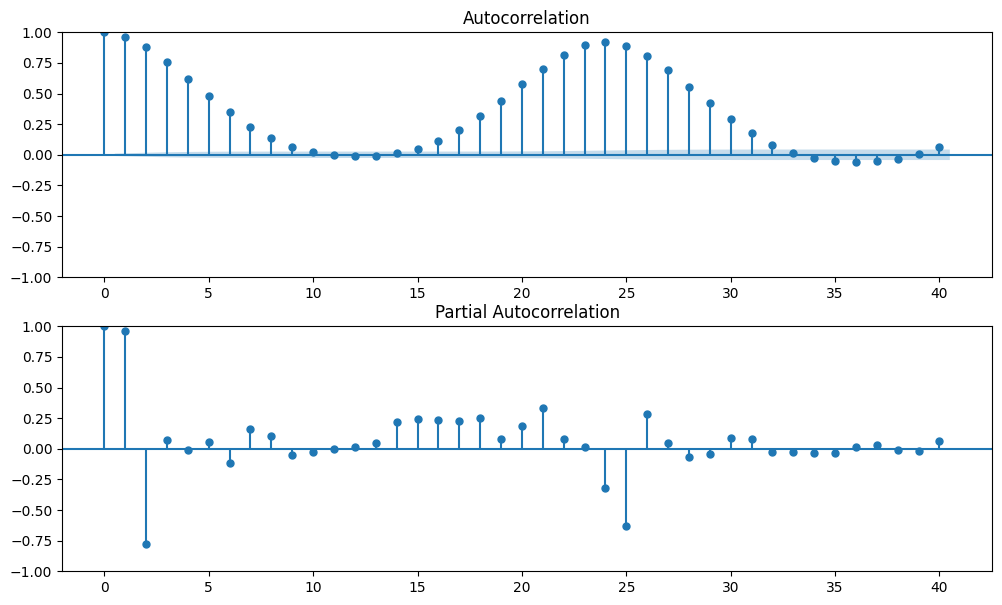

In [17]:
plot_pacf_acf( "Dağıtılan Enerji (MWh)" )

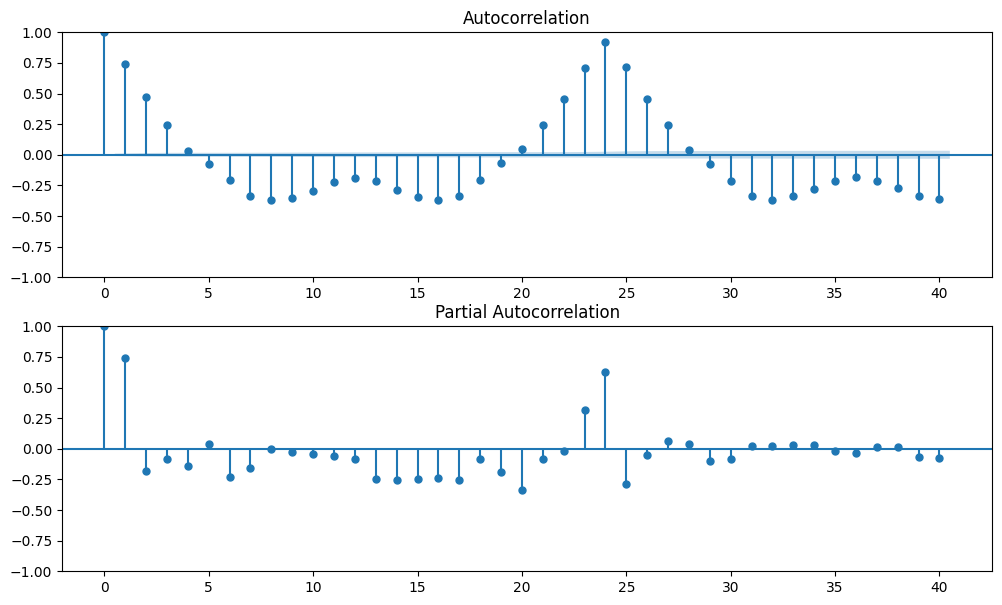

In [18]:
plot_pacf_acf( 'Close_diff' )

# ARIMA Modelling

## Functions

In [25]:
from sklearn.metrics import mean_absolute_percentage_error

In [55]:
def eval_metrics(y_true , y_pred):
    from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
    
    # MAPE hesaplama
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # r2 hesaplama
    r2 = r2_score(y_true , y_pred)
    
    # mae hesaplama
    mae = mean_absolute_error(y_true , y_pred)

    # rmse hesaplama
    rmse = mean_squared_error(y_true,y_pred)**0.5
    
    print(f"""
          Mape Score : {mape}
          R2 Score : {r2}
          MAE Score : {mae}
          RMSE Score : {rmse}
          """)
    
def eval_plot(y_true , y_pred):
    tests = pd.DataFrame(data = y_true , columns=['Real Values'] , index = data[:-24].index)
    preds = pd.DataFrame(data = y_pred , columns=['Predicts'] , index = data[:-24].index)
    compare = pd.concat([tests[:-24], preds] , axis= 1)
    print(compare.plot())
    
def eval_df (y_true , y_pred):
    compare = pd.DataFrame({'Real Values': y_true, 'Predicts': y_pred}, index=data[:-24].index)
    print(compare)
    
def create_submission(future_preds, num):
    submission_df = pd.DataFrame({'Tarih': future_data['Tarih'], 'Dağıtılan Enerji (MWh)': future_preds})
    filename = 'submission{}.csv'.format(num)
    submission_df.to_csv(filename, index=False)
    globals()['submission{}'.format(num)] = submission_df

## Modelling Time

                                 SARIMAX Results                                  
Dep. Variable:     Dağıtılan Enerji (MWh)   No. Observations:                39951
Model:                     ARIMA(1, 1, 1)   Log Likelihood             -228619.344
Date:                    Sun, 09 Apr 2023   AIC                         457244.687
Time:                            00:07:02   BIC                         457270.473
Sample:                                 0   HQIC                        457252.850
                                  - 39951                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6512      0.006    105.539      0.000       0.639       0.663
ma.L1          0.2133      0.007     32.657      0.000       0.201       0.226
sigma2      5492.160

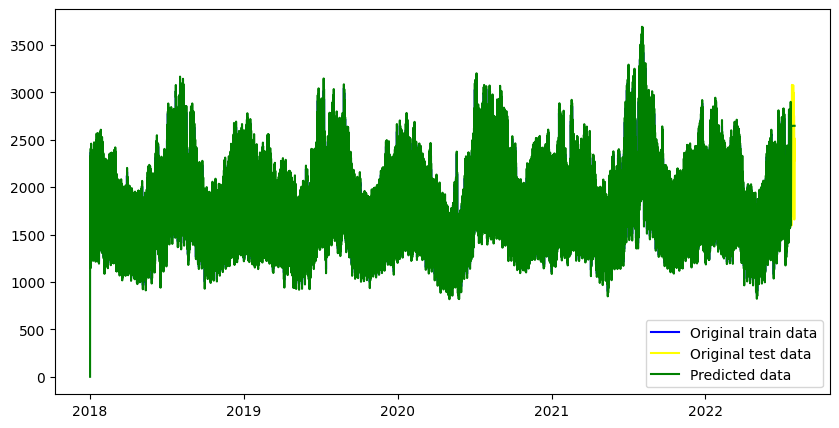

In [24]:
X_train_copy = X_train.copy()
X_train_copy.reset_index(inplace=True)

def run_model(model_params):
    model = ARIMA(X_train_copy["Dağıtılan Enerji (MWh)"], order = model_params)
    model_fit = model.fit()
    print(model_fit.summary())
    predictions = model_fit.predict(start=X_train_copy.index[0], end=X_train_copy.index[-1] + X_test.shape[0]).to_frame()
    predictions['Date'] = X_train.index.values.tolist() + X_test.index.values.tolist()
    predictions['Date'] = pd.to_datetime(predictions['Date'])
    scores = eval_metrics(X_test["Dağıtılan Enerji (MWh)"], predictions.predicted_mean[X_train_copy.index[-1] + 1:])
    print("Scores : ", scores)
    plt.figure(figsize=(10, 5))
    plt.plot(X_train.index, X_train["Dağıtılan Enerji (MWh)"], color='blue', label='Original train data')
    plt.plot(X_test.index, X_test["Dağıtılan Enerji (MWh)"], color='yellow', label='Original test data')
    plt.plot(predictions.Date, predictions.predicted_mean, color='green', label='Predicted data')
    plt.legend()
    plt.show()

run_model((1,1,1))

In [ ]:
# ARIMA modellerinde "pdq" terimi, modelin parametrelerini ifade eder. "p" otoregresif (AR) terimleri sayısını, "d" fark alma (differencing) derecesini 
# ve "q" hareketli ortalama (MA) terimleri sayısını belirtir.

# p: AR terimleri sayısı, yani geçmiş dönemlerin bağımlı değişken değerlerinin, bugünkü değer üzerindeki etkisinin kaç dönem geriye gideceği.
# d: veri serisi üzerinde uygulanacak fark alma işleminin derecesi, yani ne kadar geriye gidilerek fark alınacağı.
# q: MA terimleri sayısı, yani hataların geçmiş dönemdeki değerlerinin, bugünkü hatanın hesaplanmasında kullanılacağı dönem sayısı.
# Örneğin, "pdq" = (2,1,3) olan bir ARIMA modeli, 2 adet AR terimi, birinci dereceden fark alma ve 3 adet MA terimi içerir.

In [27]:
p_params = [ 20,30,40]
d_params = [1]
q_params = [ 30,40,50]
best_mape = 0.1969
best_params = None
result_val = []

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(X_train_copy["Dağıtılan Enerji (MWh)"], order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=X_train_copy.index[0], end=X_train_copy.index[-1] + X_test.shape[0]).to_frame()
            mape = mean_absolute_percentage_error(X_test["Dağıtılan Enerji (MWh)"], predictions.predicted_mean[X_train_copy.index[-1] + 1:])
            result_val.append((mape, (p_val, d_val, q_val)))
            if mape <= best_mape:
                best_mape = mape
                best_params = (p_val, d_val, q_val)

c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

In [29]:
best_params

(20, 1, 30)

In [ ]:
'''
run_model((20, 1, 30))

mape :  0.14431777488312392

'''

In [ ]:
'''
run_model((40, 1, 60))

mape :  0.14115334879863087

'''

c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 SARIMAX Results                                  
Dep. Variable:     Dağıtılan Enerji (MWh)   No. Observations:                39951
Model:                   ARIMA(20, 1, 30)   Log Likelihood             -204106.535
Date:                    Sun, 09 Apr 2023   AIC                         408315.069
Time:                            02:19:09   BIC                         408753.434
Sample:                                 0   HQIC                        408453.832
                                  - 39951                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4446      0.015     29.242      0.000       0.415       0.474
ar.L2         -0.1897      0.019    -10.106      0.000      -0.226      -0.153
ar.L3         -0.319

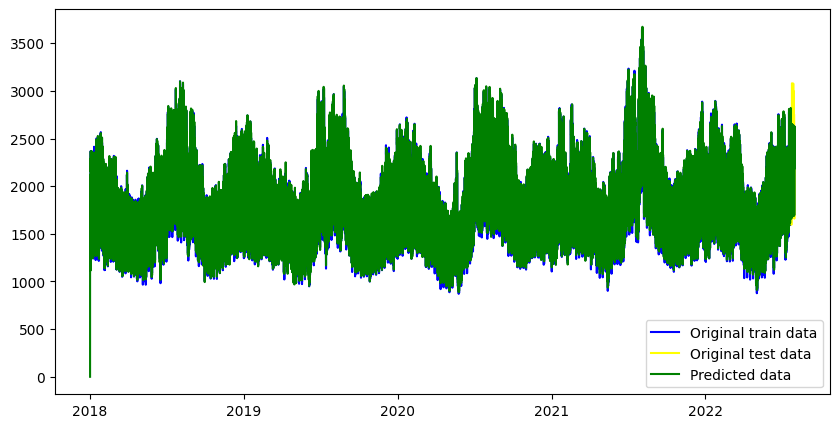

In [30]:
run_model((20, 1, 30))

# Predictions

In [36]:
model = ARIMA(data["Dağıtılan Enerji (MWh)"], order = (20, 1, 30) , freq='H')

c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [39]:
model_fit = model.fit()

c:\Users\Emincan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
start_point = -24

In [51]:
future_period = pd.Timedelta(future_data.shape[0], unit='H')
end_date = data.index[-1] + future_period
predictions = model_fit.predict(start=data.index[start_point], end=end_date, freq='H').to_frame()

In [58]:
predictions[24:].values.reshape(-1)

array([2118.30973459, 1941.23191706, 1818.31231365, 1741.01841296,
       1684.5920521 , 1678.52974067, 1652.44695838, 1712.67285334,
       1911.96324574, 2106.90694808, 2267.69041935, 2409.77797556,
       2485.97781341, 2592.55021643, 2639.4542433 , 2621.87206056,
       2613.8843007 , 2570.87105621, 2538.10158541, 2515.94264047,
       2492.14873616, 2461.45744623, 2365.78844935, 2253.21889954,
       2105.8974201 , 1921.8856308 , 1795.93913316, 1717.00382256,
       1664.19455885, 1645.17131924, 1636.80679579, 1715.86295195,
       1922.64871741, 2100.94207153, 2259.13640523, 2405.04094089,
       2484.06980306, 2576.65093411, 2629.28675638, 2627.94754948,
       2620.90206848, 2565.97424477, 2538.03483664, 2523.52568547,
       2491.92956912, 2450.32673505, 2365.00433775, 2265.26941186,
       2114.62473012, 1924.29315066, 1801.94937642, 1726.21941289,
       1661.18814779, 1635.46327442, 1639.23566185, 1726.96740845,
       1920.23760886, 2094.02099618, 2259.31771009, 2404.04046

In [59]:
create_submission(predictions[24:].values.reshape(-1) , 4)

In [ ]:
# Done